# **Importing Libraries**

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import mlflow
# import plotly.graph_objects as go


# **Reading Data**

In [3]:
df = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


# **Basic EDA**

### **checking if data is balanced**

In [4]:
df["Churn"].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

Not balanced for sure! 
Possible remedies :
1. class weights during model training.
2. data augmentation using over-sampling, under-sampling, SMOTE.
3. Trying with Ensemble methods.

- Stratification is needed during train-test split.

### **null counts**


In [5]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Phew! no null values, Thank God!

### **Fixing the data types**

In [6]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

- column *TotalCharges* should be of `float` type.
- column *SeniorCitizen* should be of `object` type.

Lets do it ...

In [7]:
# changing the total charges dtype to float
def change_dtype(value, to_type=float):
    try:
        return to_type(value)
    except:
        return None
df["TotalCharges"] = df["TotalCharges"].apply(lambda x: change_dtype(x, float))
df["SeniorCitizen"] = df["SeniorCitizen"].apply(lambda x: change_dtype(x, str))

Now we need to check how many `None`s we have got during data type transformation.

In [7]:
df[["TotalCharges", "SeniorCitizen"]].isna().sum()

TotalCharges     11
SeniorCitizen     0
dtype: int64

meh! not much. We can get rid of those.

In [8]:
print("Before : ", df.shape)
df.dropna(inplace=True)
print("After : ", df.shape)

Before :  (7043, 21)
After :  (7032, 21)


Now, lets seperate the categorical columns and numerical columns.
In the meantime lets get rid of that *customerID* column, no good there after all.


In [9]:
categorical_cols = [col for col in df.columns if df[col].dtypes == object and col not in ["customerID", "Churn"]]
numeric_cols = [col for col in df.columns if df[col].dtypes != object and col not in ["customerID", "Churn"]]
target_col = ["Churn"]

df = df[categorical_cols + numeric_cols + target_col]

### **Visualizing the relation between Categorical features and Target variable**

In [10]:
def produce_stacked_bar_chart(col1, col2, figsize=(6,4)):
    perc_df = (df.groupby([col1, col2]).size()/df.groupby([col1]).size()).unstack(fill_value=0) * 100
    plt.figure(figsize=figsize)
    perc_df.plot(kind='bar', stacked=True, color=['green', 'red'], alpha=0.7)

    # Adding labels and title
    plt.xlabel(col1)
    plt.ylabel(col2 + ' (%)')
    plt.title(f'Stacked Bar Chart for {col1} and {col2}')


/tmp/ipykernel_1558871/3299915548.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


<Figure size 600x400 with 0 Axes>

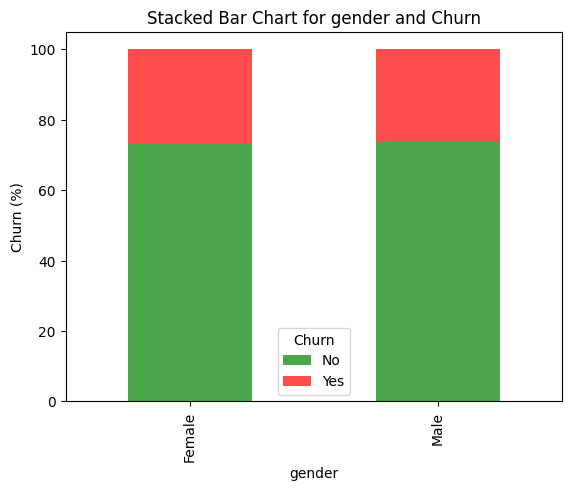

<Figure size 600x400 with 0 Axes>

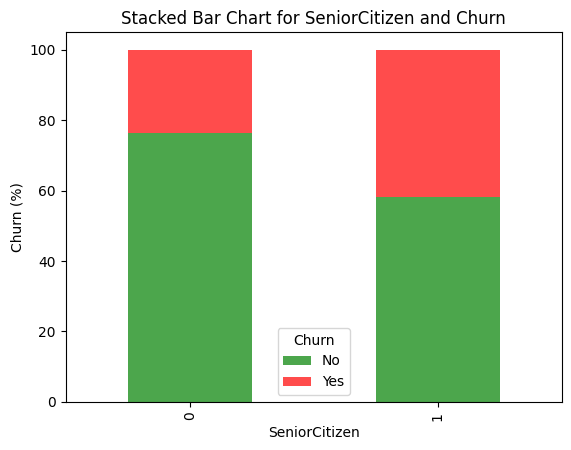

<Figure size 600x400 with 0 Axes>

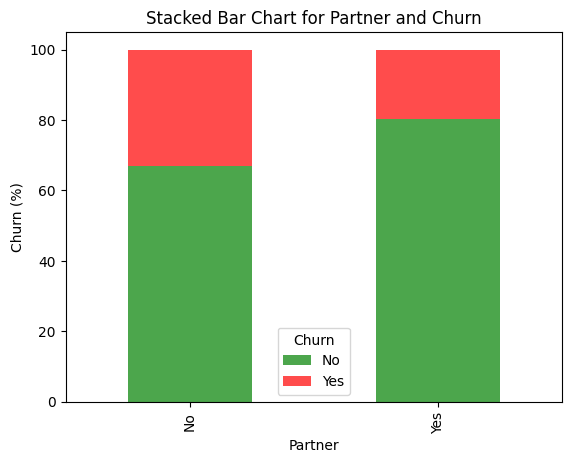

<Figure size 600x400 with 0 Axes>

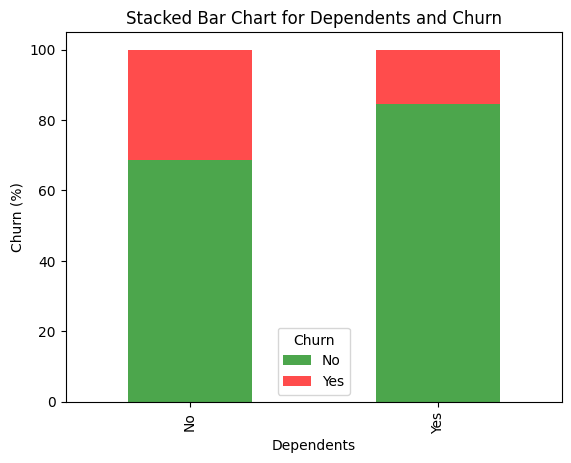

<Figure size 600x400 with 0 Axes>

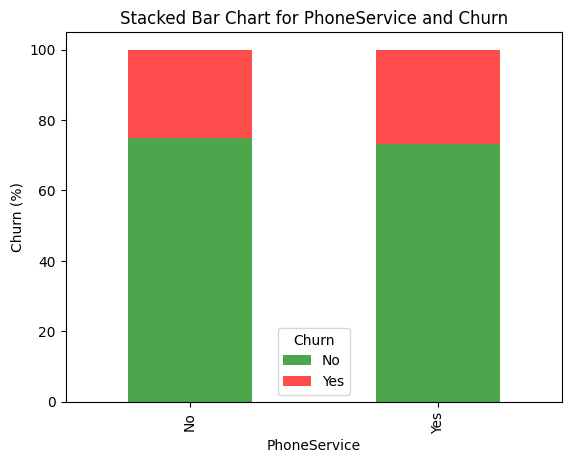

<Figure size 600x400 with 0 Axes>

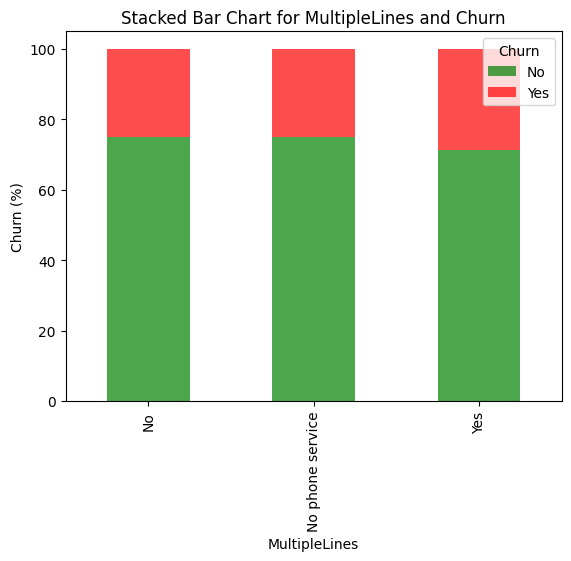

<Figure size 600x400 with 0 Axes>

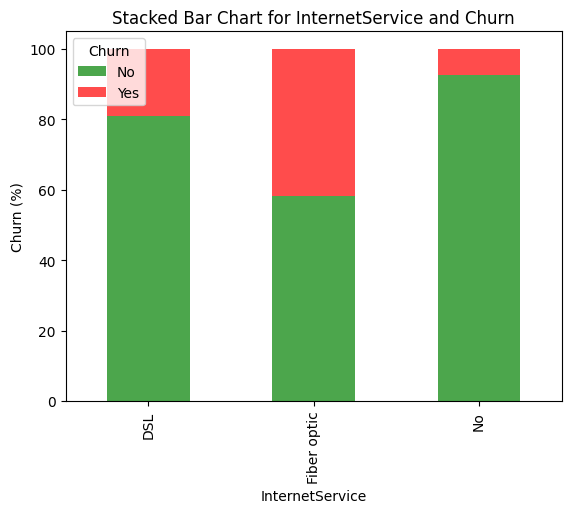

<Figure size 600x400 with 0 Axes>

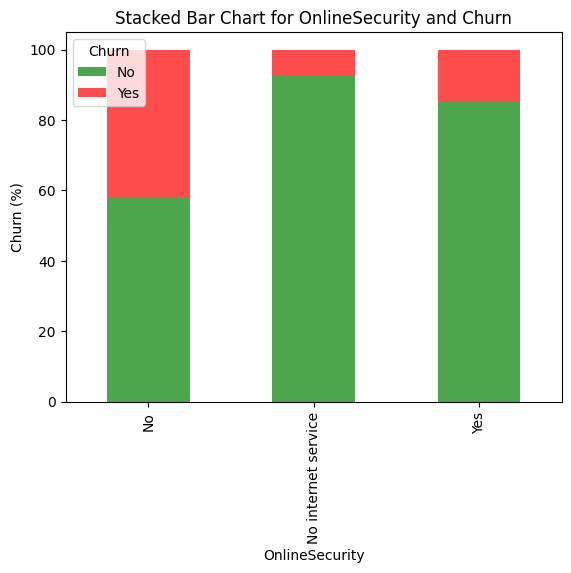

<Figure size 600x400 with 0 Axes>

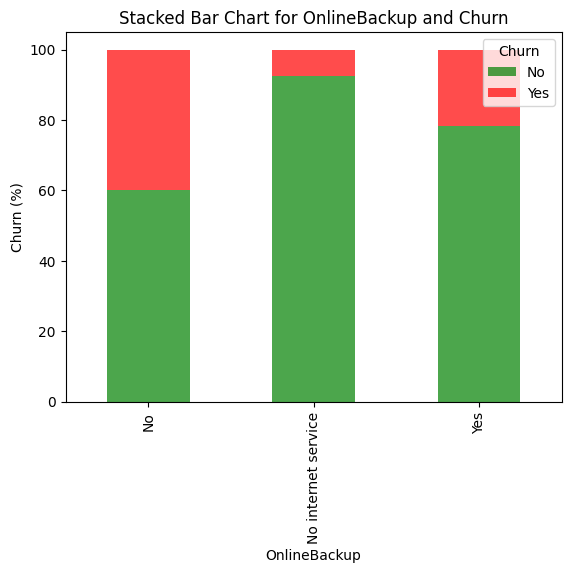

<Figure size 600x400 with 0 Axes>

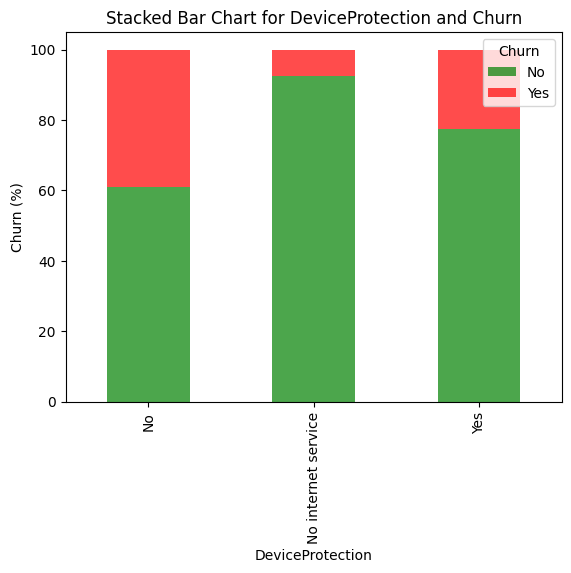

<Figure size 600x400 with 0 Axes>

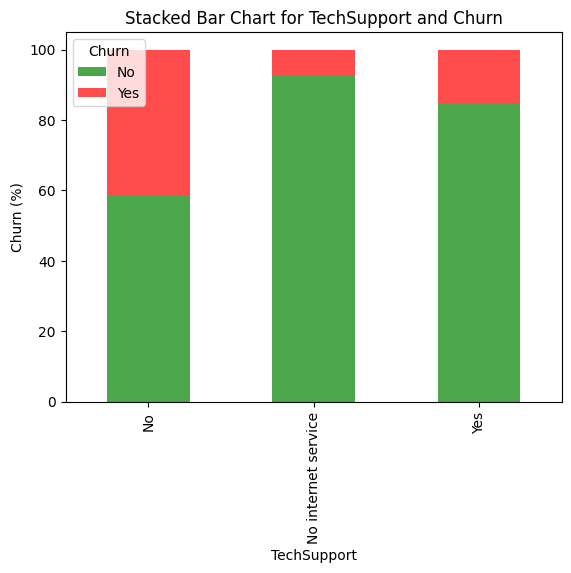

<Figure size 600x400 with 0 Axes>

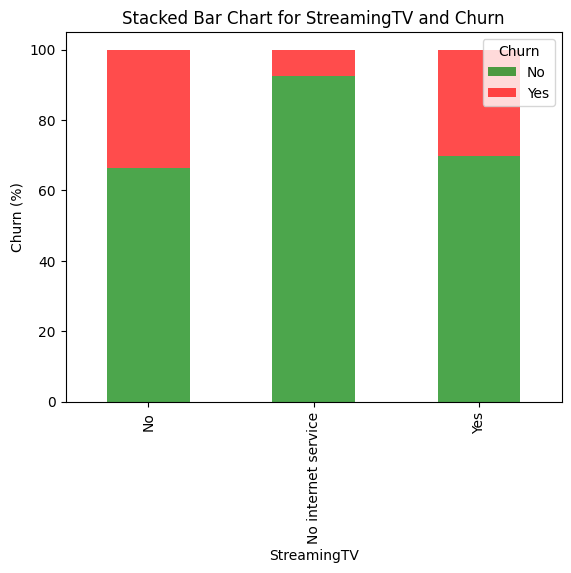

<Figure size 600x400 with 0 Axes>

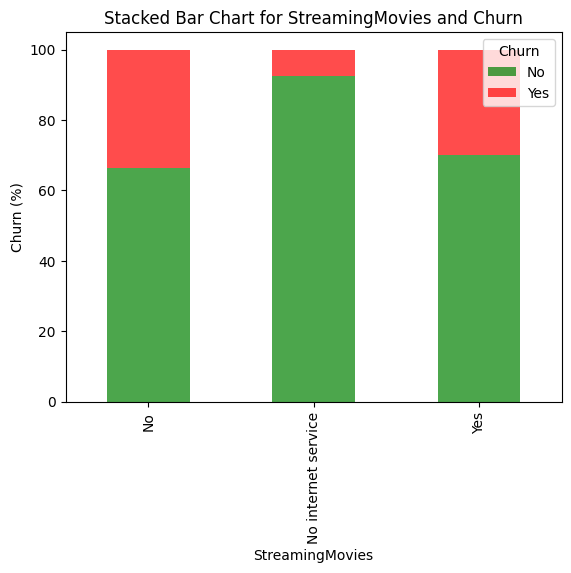

<Figure size 600x400 with 0 Axes>

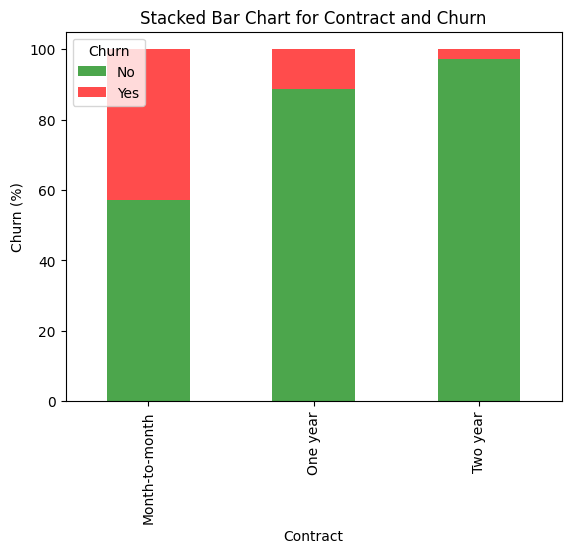

<Figure size 600x400 with 0 Axes>

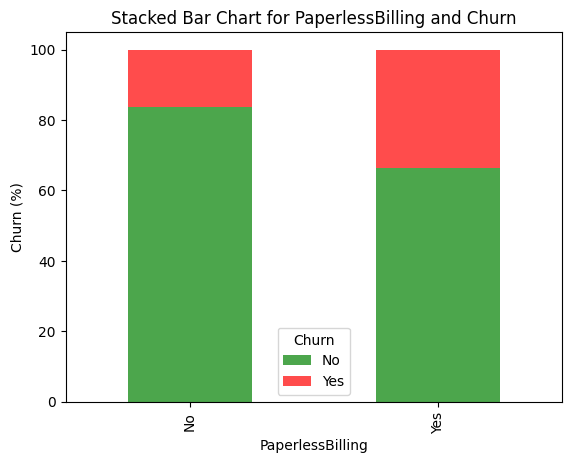

<Figure size 600x400 with 0 Axes>

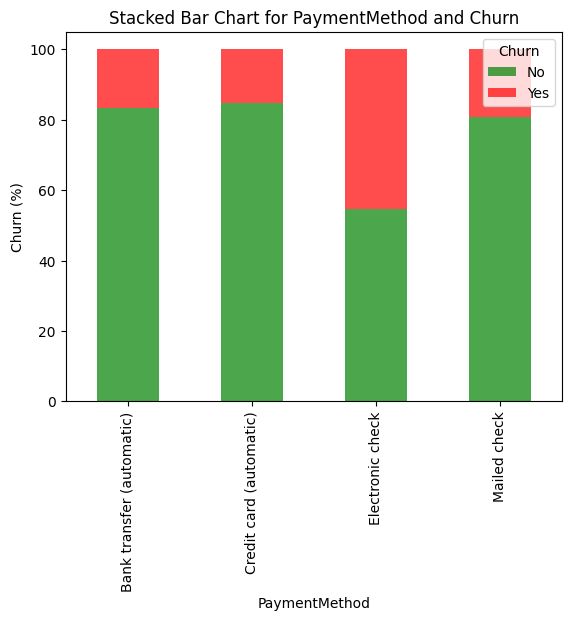

In [11]:
for col in categorical_cols:
    if col != "Churn":
        produce_stacked_bar_chart(col, "Churn")

### **Visualizing the relation between numeric variables and target variable**

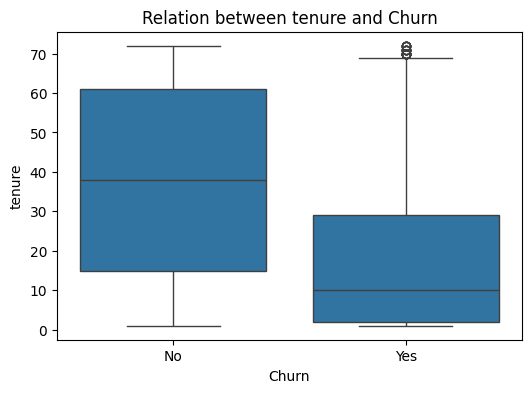

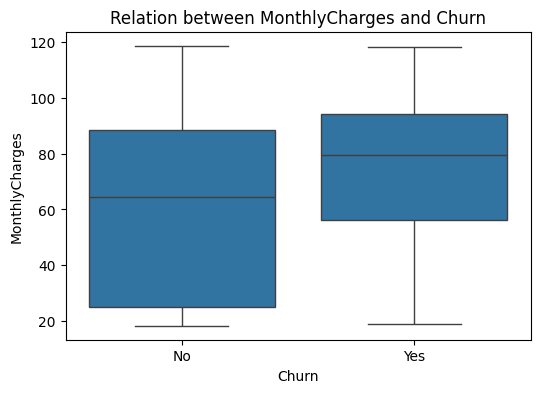

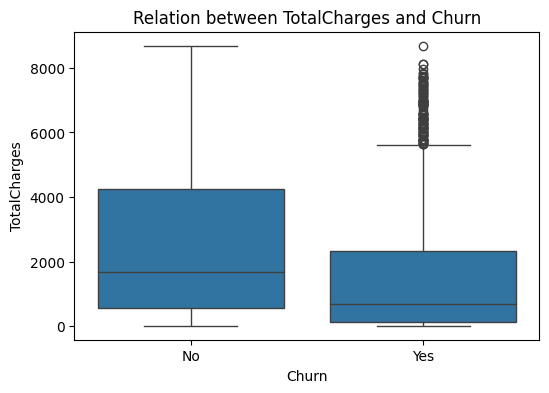

In [12]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Churn", y=col, data=df)
    plt.title(f"Relation between {col} and Churn")
    plt.show()

column *TotalCharges* has got a lot of outliers.
- If number of outliers is not much, we can delete those readily.
- If the number of outliers is high, we can impute or use algorithms that are outlier-prone

Lets check how many outliers we have got there...

In [13]:
def remove_outliers_iqr(df, column_name):
    """
    Remove outliers from a DataFrame column using the IQR method.

    Parameters:
    - df: DataFrame
    - column_name: str, the name of the column with outliers

    Returns:
    - df_outliers_removed: DataFrame, DataFrame with outliers removed
    - num_outliers: int, number of outliers removed
    """

    # Copy the original DataFrame to avoid modifying the original data
    df_outliers_removed = df.copy()

    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df_outliers_removed[column_name].quantile(0.25)
    Q3 = df_outliers_removed[column_name].quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds to identify outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify and remove outliers
    outliers_mask = (df_outliers_removed[column_name] < lower_bound) | (df_outliers_removed[column_name] > upper_bound)
    num_outliers = outliers_mask.sum()
    df_outliers_removed = df_outliers_removed[~outliers_mask]

    # Print the number of outliers removed
    print(f"Number of outliers removed in '{column_name}': {num_outliers}")

    return df_outliers_removed, num_outliers

In [14]:
print("Before no of data : ", len(df))
df1, num_outliers = remove_outliers_iqr(df, "TotalCharges")
print("After no of data : {} and no of outliers : {}".format(len(df1), num_outliers))

Before no of data :  7032
Number of outliers removed in 'TotalCharges': 0
After no of data : 7032 and no of outliers : 0


Okay, looks like the outliers are coming only for the churned members. Lets not worry about those as that can represent some of the odd cases.

# **Data Splitting into Train, Test**

we need to use stratify here , remember? as we have got an imbalanced dataset. By using stratify=y, it's ensured that both the training and testing sets have a similar distribution of classes as the original dataset, making the split more representative and maintaining the balance between classes.

In [15]:
X_df = df[categorical_cols+numeric_cols]
y_df = df[target_col]
train_X_df, test_X_df, train_y_df, test_y_df = train_test_split(X_df, y_df, test_size=0.2, stratify=y_df)

In [16]:
print("Training data size : {} {}".format(len(train_X_df), len(train_y_df)))
print("Test data size : {} {}".format(len(test_X_df), len(test_y_df)))

Training data size : 5625 5625
Test data size : 1407 1407


In [17]:
# class distributions in train test
print("in Train data :\n{}".format(train_y_df.value_counts()/train_y_df.value_counts().sum()))
print("in Test data :\n{}".format(test_y_df.value_counts()/test_y_df.value_counts().sum()))

in Train data :
Churn
No       0.734222
Yes      0.265778
Name: count, dtype: float64
in Test data :
Churn
No       0.734186
Yes      0.265814
Name: count, dtype: float64


# **Data Processing**

How to design the experiments?

- One Hot Encoding

- Data Modification :
    - Undersampling
    - Oversampling
    - SMOTE

Now here we are going to use MLflow to maintain the pipelines and versions of our different experiments...

But before that lets modify the training data with one hot encodings.

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  # Keep non-categorical columns unchanged
)
class_labels = {c:i for i,c in enumerate(set(train_y_df["Churn"]))}
print(class_labels)

# Fit and transform your data
train_X_encoded = preprocessor.fit_transform(train_X_df)
train_y_encoded = train_y_df["Churn"].map(class_labels).values

test_X_encoded = preprocessor.transform(test_X_df)
test_y_encoded = test_y_df["Churn"].map(class_labels).values

{'Yes': 0, 'No': 1}


In [20]:
train_X_encoded

array([[1.00000e+00, 0.00000e+00, 1.00000e+00, ..., 2.40000e+01,
        7.54000e+01, 1.74785e+03],
       [0.00000e+00, 1.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        7.00500e+01, 7.00500e+01],
       [1.00000e+00, 0.00000e+00, 1.00000e+00, ..., 2.00000e+00,
        6.21500e+01, 1.13100e+02],
       ...,
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 8.00000e+00,
        1.05500e+02, 8.29550e+02],
       [1.00000e+00, 0.00000e+00, 1.00000e+00, ..., 2.90000e+01,
        7.42000e+01, 1.99325e+03],
       [0.00000e+00, 1.00000e+00, 1.00000e+00, ..., 1.00000e+00,
        9.50000e+01, 9.50000e+01]])

In [19]:
train_X_df.shape, train_X_encoded.shape

((5625, 19), (5625, 46))

Now, it's time for Undersampling, Oversampling, SMOTE ...

In [ ]:

def Undersample(X,y, sampling_strategy=1.0, random_state=None):
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    return X_resampled, y_resampled


def Oversample(X, y, sampling_strategy=1.0, random_state=None):
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = ros.fit_resample(X, y)

    return X_resampled, y_resampled


def perform_smote(X, y, sampling_strategy=1.0, random_state=None):
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    return X_resampled, y_resampled

In [ ]:
print("Before undersampling :\n", train_y_df.value_counts())
train_X_enc_undersampled, train_y_undersampled = Undersample(train_X_encoded, train_y_encoded)

unique_values, counts = np.unique(train_y_undersampled, return_counts=True)
value_counts_dict = dict(zip(unique_values, counts))
print("\nAfter Undersampling :\n", value_counts_dict)

In [ ]:
print("Before oversampling :\n", train_y_df.value_counts())
train_X_enc_oversampled, train_y_oversampled = Oversample(train_X_encoded, train_y_encoded)

unique_values, counts = np.unique(train_y_oversampled, return_counts=True)
value_counts_dict = dict(zip(unique_values, counts))
print("\nAfter Oversampling :\n", value_counts_dict)

In [ ]:
print("Before SMOTE :\n", train_y_df.value_counts())
train_X_enc_smote, train_y_smote = perform_smote(train_X_encoded, train_y_encoded)

unique_values, counts = np.unique(train_y_smote, return_counts=True)
value_counts_dict = dict(zip(unique_values, counts))
print("\nAfter SMOTE :\n", value_counts_dict)

Now we have differently sampled datasets. We will now combine these datasets with different models to perform experiments and find out the best performing combination.

# **Experiments**

- Data Modification :
    - Undersampling
    - Oversampling
    - SMOTE
- Modelling :
    - Logistic Regression
    - Random Forest
    - Kernel SVM
    - XGBoost
    - LightGBM

In [ ]:
train_X_encoded.shape, train_y_encoded.shape

In [ ]:
data_processes = [("Original", train_X_encoded, train_y_encoded),
                  ("Undersampling", train_X_enc_undersampled, train_y_undersampled),
                  ("Oversampling", train_X_enc_oversampled, train_y_oversampled),
                  ("SMOTE", train_X_enc_smote, train_y_smote)]

model_algorithms = [LogisticRegression(),
                    RandomForestClassifier(),
                    SVC(kernel="rbf", probability=True),
                    XGBClassifier()]
                    # LGBMClassifier()]

local_tracking_uri = "/home/dipan.banik@sapt.local/Dipan/Telco-Churn-Prediction/notebooks/churn_experiments" 
mlflow.set_tracking_uri(local_tracking_uri)

experiment_name = "telco-churn-classification"
mlflow.set_experiment(experiment_name)

all_fpr = []
all_tpr = []
all_auc = []
experiment_names = []

for data_exp_name, train_x, train_y in data_processes:
    for model in model_algorithms:
        exp_name = data_exp_name+"-"+model.__class__.__name__
        with mlflow.start_run(run_name=exp_name):
            print(data_exp_name, model.__class__.__name__)
            
            model.fit(train_x, train_y)
            y_pred = model.predict(test_X_encoded)

            y_pred_prob = model.predict_proba(test_X_encoded)[:,1]
            fpr, tpr, _ = roc_curve(test_y_encoded, y_pred_prob)
            auc_score = auc(fpr, tpr)

            experiment_names.append(exp_name)
            all_fpr.append(fpr)
            all_tpr.append(tpr)
            all_auc.append(auc_score)

            mlflow.log_param("data", data_exp_name)
            mlflow.log_param("model", model.__class__.__name__)

            mlflow.log_metric("Accuracy", accuracy_score(test_y_encoded, y_pred))
            mlflow.log_metric("Precision", precision_score(test_y_encoded, y_pred))
            mlflow.log_metric("Recall", recall_score(test_y_encoded, y_pred))
            mlflow.log_metric("F1_score", f1_score(test_y_encoded, y_pred))

            mlflow.sklearn.log_model(model, "model")
                     


To run the mlflow experiments dashboard, Go to the *notebooks/* folder where mlflow logs folder (*churn_experiments/*) is located. Run `mlflow ui --backend-store-uri=churn_experiments` in the terminal to get the port where the dashboard will be displayed. Typically that will be : `http://127.0.0.1:5000`

In [ ]:
plt.figure(figsize=(8, 8))

for i, exp_name in enumerate(experiment_names):
    plt.plot(all_fpr[i], all_tpr[i], label=f'Model {exp_name} (AUC = {all_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - All Models')
# plt.legend(loc="lower right")
plt.legend(loc="upper right", bbox_to_anchor=(1.65, 1), borderaxespad=0, fontsize='small')

plot_filename = "../plots/roc_curve_all_models.png"
plt.savefig(plot_filename, bbox_inches='tight')
plt.close()

mlflow.log_artifact(plot_filename, "roc_curves")